# Heterogeneous analysis

Based on spots (by CONCH) marked as tumor, compare and see how much they vary based ST data

In [3]:
%matplotlib inline
import numpy as np

from hest import iter_hest
import scanpy as sc
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from napari_spatialdata import Interactive
from spatialdata import SpatialData

In [173]:
case = 'NCBI785' #TENX95' #NCBI783 NCBI785

In [174]:
# Iterate through a subset of hest
for st in iter_hest('/mnt/c/data//hest_data', id_list=[case]):

    # ST (adata):
    adata = st.adata
    print('\n* Scanpy adata:')
    print(adata)

    # WSI:
    wsi = st.wsi
    print('\n* WSI:')
    print(wsi)
    
    # Shapes:
    shapes = st.shapes
    print('\n* Shapes:')
    print(shapes)
    
    # Tissue segmentation
    tissue_contours = st.tissue_contours
    print('\n* Tissue contours:')
    print(tissue_contours)
    
    # # Conversion to SpatialData
    # sdata = st.to_spatial_data()
    # print('\n* SpatialData conversion:')
    # print(sdata)


* Scanpy adata:
AnnData object with n_obs × n_vars = 4180 × 541
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

* WSI:
<width=30786, height=24241, backend=CuImageWSI>

* Shapes:
[name: cellvit, coord-system: he, <not loaded>, name: xenium_cell, coord-system: he, <not loaded>, name: xenium_nucleus, coord-system: he, <not loaded>]

* Tissue contours:
  tissue_id                                           geometry
0         0  POLYGON ((15962 3757, 15950 3769, 15950 3781, ...
1         1  POLYGON ((2225

/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/scanpy/preprocessing/_qc.py:432: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]


In [175]:
# Read CONCH predictions
conch_pred = np.load(f'/mnt/c/src/CONCH/{case}_predictions.npz', allow_pickle=True)
# read the predictions
conch_pred['predictions'].shape

(4074,)

In [176]:
barcodes = []
for barcode in conch_pred['barcodes']:
    barcodes.append((barcode[0].decode('utf-8')))
    

In [177]:
adata.obs.loc[barcodes, 'predictions'] = conch_pred['predictions']

In [178]:
print(adata.obs.columns)

Index(['in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col',
       'array_row', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mito',
       'log1p_total_counts_mito', 'pct_counts_mito', 'predictions'],
      dtype='object')


In [179]:
adata.obs['predictions']

000x000    2.0
000x001    2.0
000x002    2.0
000x003    2.0
000x004    0.0
          ... 
054x071    2.0
054x072    2.0
054x073    2.0
054x074    2.0
054x075    2.0
Name: predictions, Length: 4180, dtype: float64

/tmp/ipykernel_2111574/3416106697.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


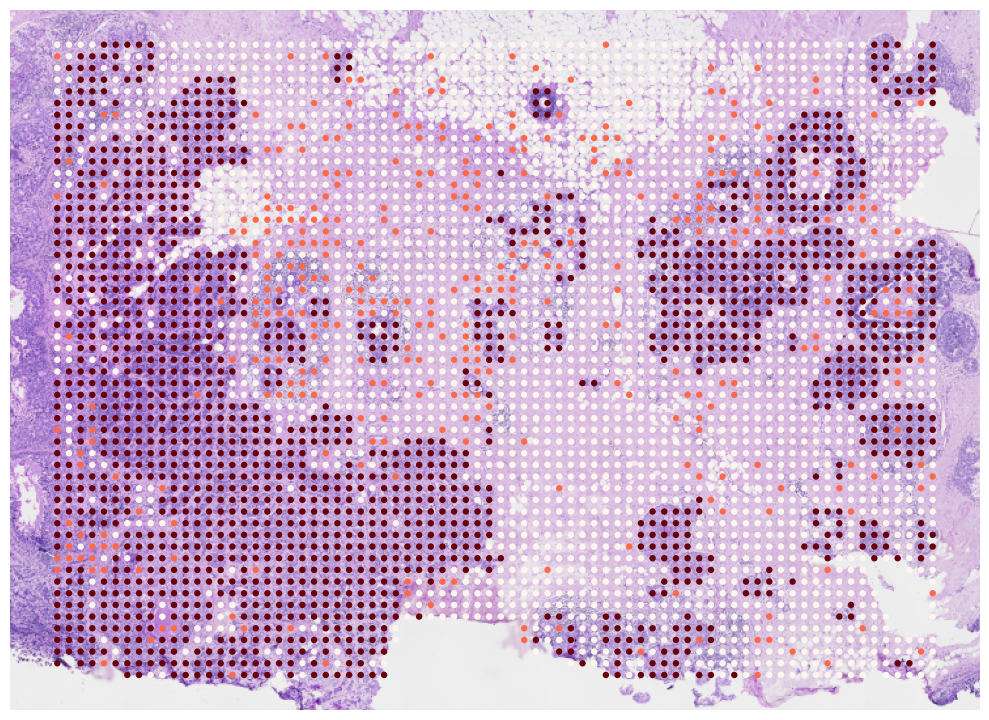

In [180]:
# plt.figure(figsize=(30, 30))
# crop_coord=(1000, 47000, 3000, 55000), 

img_size = 15000
top_left = 3500

fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", 
                    color=['predictions'], title='', 
                    return_fig=True, frameon=False, bw=False, colorbar_loc=None,
                    size=1, cmap='Reds_r') 

fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
fig.show()

## Compare tumor spots only

Strategies:
1. Look at specific genes and plot variance
2. Plot ST data with UMAP for selected spots

In [181]:
tumor_barcodes = adata.obs[adata.obs['predictions'] == 0].index
tumor_barcodes

Index(['000x004', '000x005', '000x006', '000x007', '000x008', '000x070',
       '000x071', '000x072', '000x075', '001x002',
       ...
       '054x028', '054x047', '054x048', '054x050', '054x051', '054x052',
       '054x053', '054x055', '054x056', '054x058'],
      dtype='object', length=1599)

/tmp/ipykernel_2111574/3152171563.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


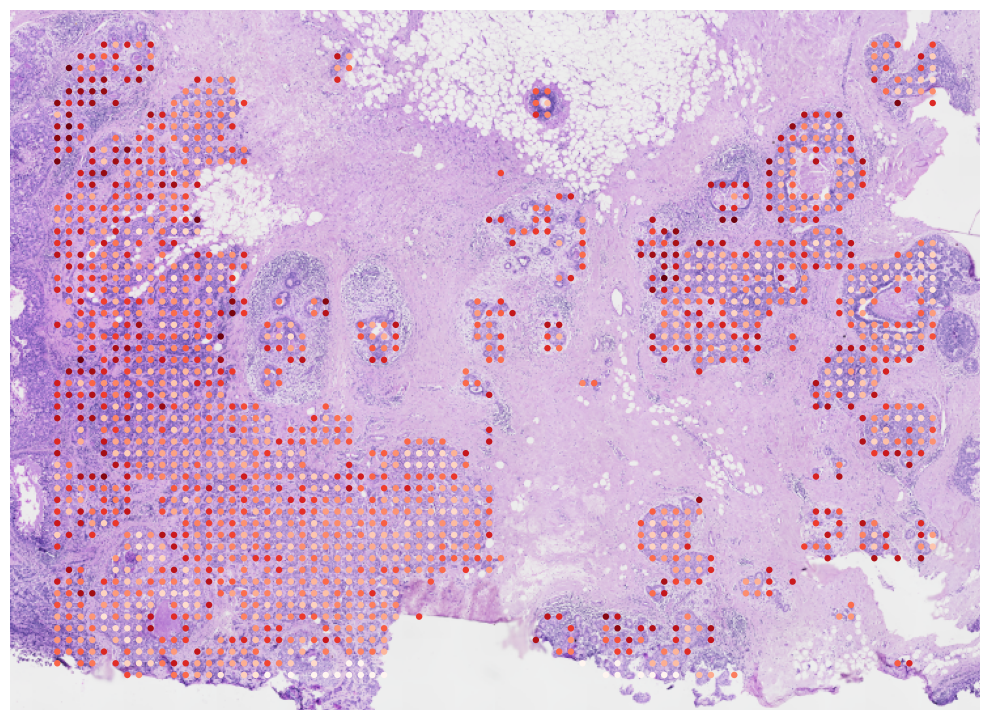

In [182]:
fig = sc.pl.spatial(adata[tumor_barcodes], show=False, img_key="downscaled_fullres", 
                    color=['pct_counts_in_top_100_genes'], title='', 
                    return_fig=True, frameon=False, bw=False, colorbar_loc=None,
                    size=1, cmap='Reds_r') 

fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
fig.show()

In [183]:
# !pip install spatialdata-io
# !pip install spatialdata-plot

## Interactive visualization

In [184]:
import spatialdata as sd
import squidpy as sq
from spatialdata_io.experimental import from_legacy_anndata, to_legacy_anndata
import spatialdata_plot

In [185]:
sdata = from_legacy_anndata(adata)
sdata

SpatialData object
├── Shapes
│     └── 'locations': GeoDataFrame shape: (4180, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (4180, 541)
with coordinate systems:
    ▸ 'global', with elements:
        locations (Shapes)

In [186]:
img_adata = adata.uns['spatial']['ST']['images']['downscaled_fullres']
scale_factors = adata.uns['spatial']['ST']['scalefactors']

sq_img = sq.im.ImageContainer(img_adata, layer="img1", dims=("y", "x", "channels"))
sq_img
# type(img)

ImageContainer[shape=(787, 1000), layers=['img1']]

In [187]:
scale_factors

{'spot_diameter_fullres': 151.13593950406488,
 'tissue_downscaled_fullres_scalef': 0.03248229714805431}

In [188]:
img = sq_img['img1'].squeeze().transpose("channels", "y", "x").to_numpy()


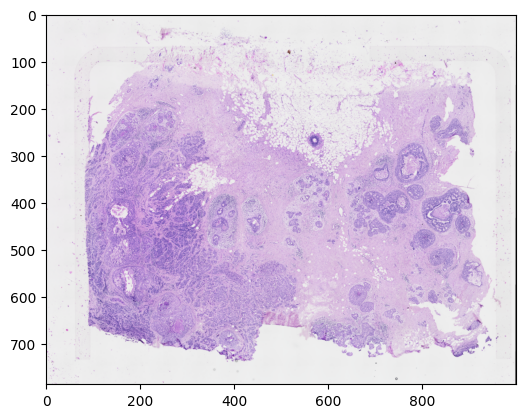

In [189]:
plt.imshow(img.transpose(1, 2, 0))  # matplotlib expects (x, y, c)

In [190]:
from spatialdata.models import Image2DModel, ShapesModel, TableModel
img_for_sdata = Image2DModel.parse(data=img, scale_factors=(2, 2, 2))  # this creates 4 downscaled images as well
img_for_sdata

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


<xarray.DataTree>
Group: /
├── Group: /scale0
│       Dimensions:  (c: 3, y: 787, x: 1000)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 6kB 0.5 1.5 2.5 3.5 4.5 ... 783.5 784.5 785.5 786.5
│         * x        (x) float64 8kB 0.5 1.5 2.5 3.5 4.5 ... 996.5 997.5 998.5 999.5
│       Data variables:
│           image    (c, y, x) uint8 2MB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── Group: /scale1
│       Dimensions:  (c: 3, y: 393, x: 500)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 3kB 1.001 3.004 5.006 7.009 ... 780.0 782.0 784.0 786.0
│         * x        (x) float64 4kB 1.0 3.0 5.0 7.0 9.0 ... 993.0 995.0 997.0 999.0
│       Data variables:
│           image    (c, y, x) uint8 590kB dask.array<chunksize=(3, 256, 256), meta=np.ndarray>
├── Group: /scale2
│       Dimensions:  (c: 3, y: 196, x: 250)
│       Coordinates:
│         * c        (c) int64 24B 0 1 2
│         * y        (y) float64 2kB 2.008 6.023 10.04 14.05 ... 772.9 777.0 781.0 785.0
│         * x        (x) float64 2kB 2.0 6.0 10.0 14.0 18.0 ... 986.0 990.0 994.0 998.0
│       Data variables:
│           image    (c, y, x) uint8 147kB dask.array<chunksize=(3, 196, 250), meta=np.ndarray>
└── Group: /scale3
        Dimensions:  (c: 3, y: 98, x: 125)
        Coordinates:
          * c        (c) int64 24B 0 1 2
          * y        (y) float64 784B 4.015 12.05 20.08 28.11 ... 766.9 775.0 783.0
          * x        (x) float64 1kB 4.0 12.0 20.0 28.0 36.0 ... 972.0 980.0 988.0 996.0
        Data variables:
            image    (c, y, x) uint8 37kB dask.array<chunksize=(3, 98, 125), meta=np.ndarray>

In [191]:
centers = adata.obsm["spatial"]
centers

array([[ 6115.31127693,  6878.06653419],
       [ 6390.10389421,  6878.06653419],
       [ 6664.89651149,  6878.06653419],
       ...,
       [26175.17233838, 21716.86786732],
       [26449.96495566, 21716.86786732],
       [26724.75757294, 21716.86786732]])

In [192]:
import pandas as pd
df = pd.concat(
    [adata.obs[["array_col", "array_row"]].reset_index(drop=True), pd.DataFrame(centers, columns=["x", "y"])],
    axis=1,
    ignore_index=True,
)
df.columns = ["array_col", "array_row", "spot_center_x", "spot_center_y"]
df

array_col  array_row  spot_center_x  spot_center_y
0             0          0    6115.311277    6878.066534
1             1          0    6390.103894    6878.066534
2             2          0    6664.896511    6878.066534
3             3          0    6939.689129    6878.066534
4             4          0    7214.481746    6878.066534
...         ...        ...            ...            ...
4175         71         54   25625.587104   21716.867867
4176         72         54   25900.379721   21716.867867
4177         73         54   26175.172338   21716.867867
4178         74         54   26449.964956   21716.867867
4179         75         54   26724.757573   21716.867867

[4180 rows x 4 columns]

In [193]:
# each spot is 55 µm in diameter
radius = (scale_factors['spot_diameter_fullres'] / 2) * scale_factors['tissue_downscaled_fullres_scalef'] 
radius

2.4546212483606977

In [194]:
import geopandas as gpd
from shapely.geometry import Point

In [195]:
centers_scaled = centers* scale_factors['tissue_downscaled_fullres_scalef'] 

In [196]:
df = pd.DataFrame([radius] * len(centers_scaled), columns=["radius"])
gdf = gpd.GeoDataFrame(df, geometry=[Point(x, y) for x, y in centers_scaled])
shapes_for_sdata = ShapesModel.parse(gdf)
shapes_for_sdata

radius                 geometry
0     2.454621  POINT (198.639 223.415)
1     2.454621  POINT (207.565 223.415)
2     2.454621  POINT (216.491 223.415)
3     2.454621  POINT (225.417 223.415)
4     2.454621  POINT (234.343 223.415)
...        ...                      ...
4175  2.454621  POINT (832.378 705.414)
4176  2.454621  POINT (841.304 705.414)
4177  2.454621   POINT (850.23 705.414)
4178  2.454621  POINT (859.156 705.414)
4179  2.454621  POINT (868.082 705.414)

[4180 rows x 2 columns]

In [197]:
# import contextlib

# # remove remnants of previous way to store spatial data
# with contextlib.suppress(KeyError):
#     del adata.uns["spatial"]

# with contextlib.suppress(KeyError):
#     del adata.obsm["spatial"]

In [198]:
adata_for_sdata = TableModel.parse(adata)

In [199]:
adata_for_sdata.uns["spatialdata_attrs"] = {
    "region": "spots",  # name of the Shapes element we will use later (i.e. the object with centers
    # and radii of the Visium spots)
    "region_key": "region",  # column in adata.obs that will link a given obs to the elements it annotates
    "instance_key": "spot_id",  # column that matches a given obs in the table to a given circle
}
# all the rows of adata annotate the same element, called "spots" (as we declared above)
adata.obs["region"] = pd.Categorical(["spots"] * len(adata))
adata.obs["spot_id"] = shapes_for_sdata.index
adata.obs[["region", "spot_id"]]

region  spot_id
000x000  spots        0
000x001  spots        1
000x002  spots        2
000x003  spots        3
000x004  spots        4
...        ...      ...
054x071  spots     4175
054x072  spots     4176
054x073  spots     4177
054x074  spots     4178
054x075  spots     4179

[4180 rows x 2 columns]

In [200]:
sdata = sd.SpatialData(
    images={"hne": img_for_sdata},
    shapes={"spots": shapes_for_sdata},
    tables={"adata": adata_for_sdata},
)
sdata

SpatialData object
├── Images
│     └── 'hne': DataTree[cyx] (3, 787, 1000), (3, 393, 500), (3, 196, 250), (3, 98, 125)
├── Shapes
│     └── 'spots': GeoDataFrame shape: (4180, 2) (2D shapes)
└── Tables
      └── 'adata': AnnData (4180, 541)
with coordinate systems:
    ▸ 'global', with elements:
        hne (Images), spots (Shapes)

/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning: Key `spots` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/spatialdata/_core/_elements.py:125: UserWarning: Key `adata` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/spatialdata/_core/_elements.py:105: UserWarning:

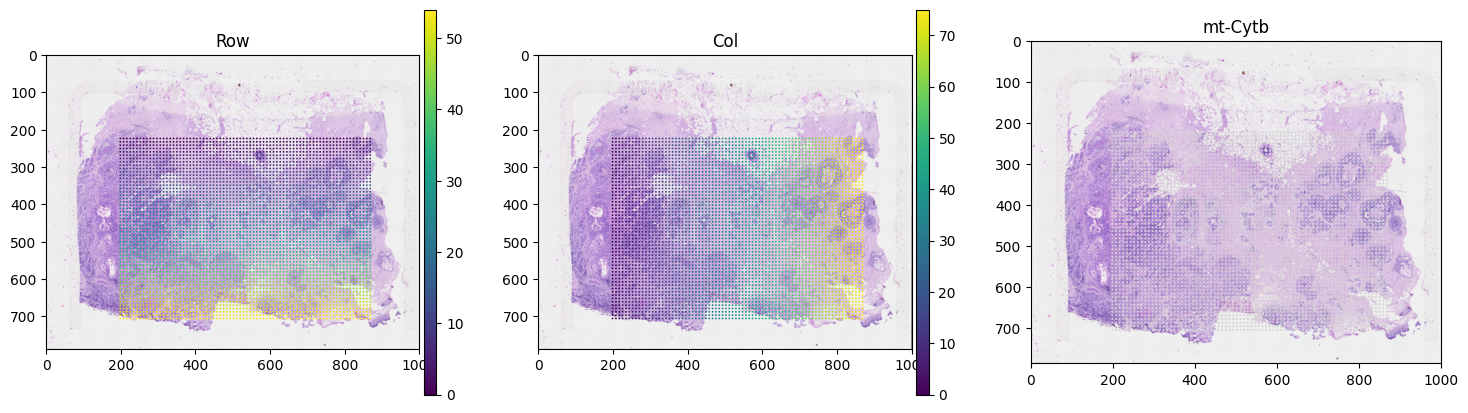

In [201]:
ig, axs = plt.subplots(1, 3, figsize=(18, 5))

sdata.pl.render_images().pl.render_shapes(color="array_row").pl.show(ax=axs[0], title="Row")

sdata.pl.render_images().pl.render_shapes(color="array_col").pl.show(ax=axs[1], title="Col")

sdata.pl.render_images().pl.render_shapes(color="mt-Cytb").pl.show(ax=axs[2], title="mt-Cytb")

In [ ]:
interactive = Interactive(sdata, headless=True)
interactive.run()

/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


14:23:32 | DEBUG | Updating layer.
14:23:32 | DEBUG | Updating layer.
14:23:33 | DEBUG | Updating layer.
14:23:33 | DEBUG | Updating layer.
14:23:33 | DEBUG | Updating layer.


## Make a UMAP of the ST data for the predictions

In [203]:
from umap import UMAP

In [204]:
import json
with open('/mnt/c/data/hest_data/filtered_genes.json', 'r') as f:
    selected_genes = json.load(f)
adata = adata[:, selected_genes]

In [205]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [206]:
adata[tumor_barcodes].X.shape

(1599, 280)

In [207]:
# UMAP
reducer = UMAP()
embedding = reducer.fit_transform(adata[tumor_barcodes].X)

/home/kstacke/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [208]:
embedding.shape

(1599, 2)

<Axes: >

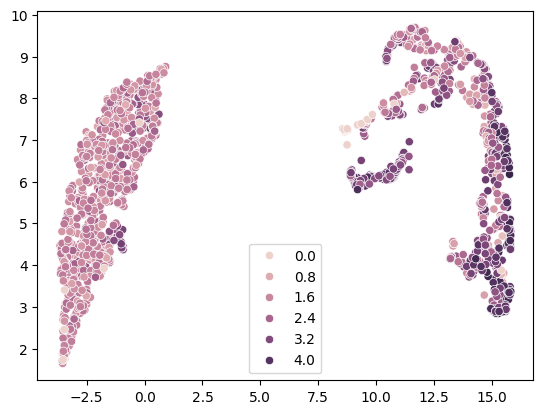

In [209]:
import seaborn as sns
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=adata[tumor_barcodes, 'ESR1'].X.squeeze())

In [210]:
adata[:, 'ESR1'].X.squeeze()

ArrayView([0.96602607, 1.2644466 , 1.2660806 , ..., 1.691989  ,
           2.0938532 , 0.        ], dtype=float32)

In [211]:
adata.obs.loc[tumor_barcodes, 'UMAP1'] = embedding[:, 0]
adata.obs.loc[tumor_barcodes, 'UMAP2'] = embedding[:, 1]

/tmp/ipykernel_2111574/313304798.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


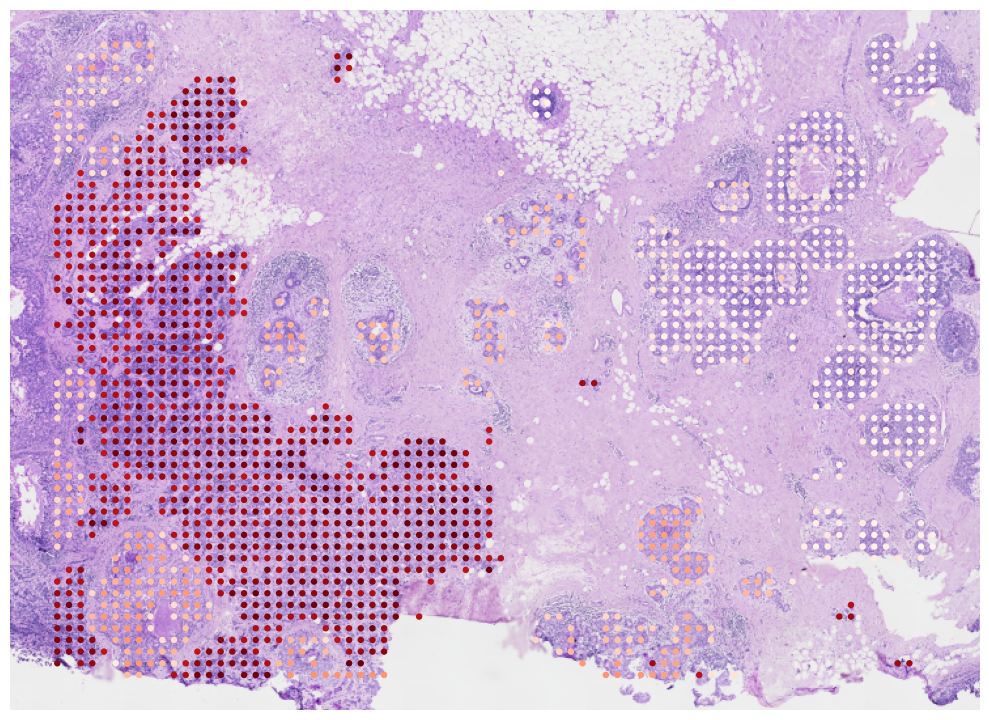

14:23:10 | DEBUG | Updating layer.
14:23:10 | DEBUG | Updating layer.
14:23:10 | DEBUG | Updating layer.


/home/kstacke/miniconda3/envs/hest/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [212]:
fig = sc.pl.spatial(adata[tumor_barcodes], show=False, img_key="downscaled_fullres", 
                    color=['UMAP1'], title='', 
                    return_fig=True, frameon=False, bw=False, colorbar_loc=None,
                    size=1, cmap='Reds_r') 

fig.set_figheight(10)
fig.set_figwidth(10)
fig.tight_layout()
fig.show()